In [1]:
%reload_ext autoreload
%autoreload 2

import mlflow
import os
import numpy as np
import pandas as pd
import pendulum
import sys
import xgboost as xgb

from loguru import logger
from pathlib import Path
from pycaret import regression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor


sys.path.append(str(Path.cwd().parent))
sys.path.append(os.path.join(str(Path.cwd().parent), "src"))
from settings.params import *
from metrics import eval_metrics
from pipeline import define_pipeline
from plot import prediction_error_plot, residual_plot
from tracking import mlflow_log_search

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [2]:
data = pd.read_csv(CLEANED_DATA)
TARGET_NAME = MODEL_PARAMS['TARGET_NAME']

In [3]:
mlflow.set_tracking_uri(uri="http://localhost:8080")

# Modeling


## Train/Test Split


In [4]:
x_train, x_test, y_train, y_test = train_test_split(data, data[TARGET_NAME], test_size=MODEL_PARAMS["TEST_SIZE"], random_state=SEED)

logger.info(f"\nX train: {x_train.shape}\nY train: {y_train.shape}\n"
            f"X test: {x_test.shape}\nY test: {y_test.shape}")

2024-08-05 22:31:01.078 | INFO     | __main__:<module>:3 - 
X train: (5205, 7)
Y train: (5205,)
X test: (1302, 7)
Y test: (1302,)


## Training


In [5]:
df = x_train.copy()
df[TARGET_NAME] = np.log(y_train)

In [6]:
exp_reg = regression.setup(df, target=TARGET_NAME, max_encoding_ohe=200, log_experiment=True, experiment_name="building-energy-prediction-training", train_size=0.8)
regression.set_config('seed', SEED)

# Removing useless metrics improve training speed
regression.remove_metric('MAPE')
regression.remove_metric('MSE')
regression.remove_metric('RMSLE')

,Description,Value
0,Session id,1893
1,Target,SiteEnergyUse(kBtu)
2,Target type,Regression
3,Original data shape,"(5205, 7)"
4,Transformed data shape,"(5205, 67)"
5,Transformed train set shape,"(4164, 67)"
6,Transformed test set shape,"(1041, 67)"
7,Numeric features,4
8,Categorical features,2
9,Preprocess,True


In [7]:
best_threes_model = regression.compare_models(n_select=3)

,Model,MAE,RMSE,R2,TT (Sec)
et,Extra Trees Regressor,0.2484,0.4361,0.8345,0.3330
rf,Random Forest Regressor,0.2863,0.4447,0.8278,0.4090
xgboost,Extreme Gradient Boosting,0.3210,0.4608,0.8156,0.4540
lightgbm,Light Gradient Boosting Machine,0.3524,0.4937,0.7884,0.3610
gbr,Gradient Boosting Regressor,0.3706,0.5087,0.7754,0.1930
dt,Decision Tree Regressor,0.2959,0.5216,0.7637,0.0340
ada,AdaBoost Regressor,0.5056,0.6579,0.6245,0.1340
ridge,Ridge Regression,0.5090,0.6737,0.6071,0.0280
br,Bayesian Ridge,0.5090,0.6737,0.6071,0.0310
lr,Linear Regression,0.5090,0.6742,0.6066,0.7080


2024/08/05 22:31:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run Extra Trees Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/5f502b01f0dc4b6e8f7e8fad8aa248e8.


2024/08/05 22:31:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:37 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/5b8004196eeb48888f8b7f9e248f6fb7.


2024/08/05 22:31:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run Extreme Gradient Boosting at: http://localhost:8080/#/experiments/584040955558151400/runs/9ada3623c05f42d6a97f564caff9e1ba.


2024/08/05 22:31:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run Light Gradient Boosting Machine at: http://localhost:8080/#/experiments/584040955558151400/runs/9678e578c72c47f5a2a82df38079dd43.


2024/08/05 22:31:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run Gradient Boosting Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/80bf746e06174ae6bd1082ede01f8447.


2024/08/05 22:31:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run Decision Tree Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/ed39af6e7d25421f817d47ca407d05ea.


2024/08/05 22:31:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run AdaBoost Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/2f0a54150ae8405eacd578cc6bcaca60.


2024/08/05 22:31:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run Ridge Regression at: http://localhost:8080/#/experiments/584040955558151400/runs/64a778383b35470c80164330b40e5ee5.


2024/08/05 22:31:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run Bayesian Ridge at: http://localhost:8080/#/experiments/584040955558151400/runs/675aa36fea6240d59e2a087580d0df70.


2024/08/05 22:31:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run Linear Regression at: http://localhost:8080/#/experiments/584040955558151400/runs/068c8c64789d468e8a5f3663a8ea582a.


2024/08/05 22:31:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run K Neighbors Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/2889d0b8c4e94bb798a091db21092074.


2024/08/05 22:31:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run Orthogonal Matching Pursuit at: http://localhost:8080/#/experiments/584040955558151400/runs/63c08597278c4ae886843687b6b14d96.


2024/08/05 22:31:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run Lasso Regression at: http://localhost:8080/#/experiments/584040955558151400/runs/e2ca71feefbe4e5c96445bdf7ef28b96.


2024/08/05 22:31:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run Elastic Net at: http://localhost:8080/#/experiments/584040955558151400/runs/bd976d8295ac4588949b250d9719a3e3.


2024/08/05 22:31:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:41 INFO mlflow.tracking._tracking_service.client: 🏃 View run Lasso Least Angle Regression at: http://localhost:8080/#/experiments/584040955558151400/runs/a7b10f9225d445e9bb6f3a8fd210df5a.


2024/08/05 22:31:41 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run Dummy Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/0dc1b679c50b481784e1589c482e6b6d.


2024/08/05 22:31:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run Huber Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/edb8f16fa0b54e67a216d5d8e2fc4d12.


2024/08/05 22:31:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run Passive Aggressive Regressor at: http://localhost:8080/#/experiments/584040955558151400/runs/1c04b6c93a224046b4ab85297f3311ff.


2024/08/05 22:31:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


2024/08/05 22:31:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:31:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run Least Angle Regression at: http://localhost:8080/#/experiments/584040955558151400/runs/1a8ab11380614426b4483df856c399cb.


2024/08/05 22:31:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


In [8]:
mlflow.end_run()

2024/08/05 22:31:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run Session Initialized a25f at: http://localhost:8080/#/experiments/584040955558151400/runs/445bae09f28c4da99a9bfb7296db8f56.


2024/08/05 22:31:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/584040955558151400.


L'entrainement sur plusieurs types de modèles avec PyCaret montre que pour ce problème, les modèles: ExtraTreesRegressor, XGBRegressor et RandomForestRegressor sont les plus adaptés. Toutefois, nous pensons que les performances obtenus lors de ce premier entrainement peuvent être nettement améliorées. Nous allons attendre de faire le réglage de paramètres et d'obtenir les modèles finaux avant de faire un choix.


## Fine-Tuning


In [9]:
ESTIMATOR_PARAMS = {
    ExtraTreesRegressor.__name__: {
        "estimator": ExtraTreesRegressor(),
        "params": {
            'regressor__estimator__n_estimators': np.arange(10, 200, 5),
        }
    },
    RandomForestRegressor.__name__: {
        "estimator": RandomForestRegressor(),
        "params": {
            'regressor__estimator__n_estimators': np.arange(10, 200, 5),
        }
    },
    xgb.XGBRegressor.__name__: {
        "estimator": xgb.XGBRegressor(),
        "params": {
            'regressor__estimator__n_estimators': np.arange(10, 200, 5),
        }
    }
}

In [10]:
CURRENT_DATE = pendulum.now()

search_cvs = {}

def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

scoring = {'r2': make_scorer(r2_score),
          'rmse': make_scorer(rmse, greater_is_better=False),
          'mae': make_scorer(mean_absolute_error, greater_is_better=False)}

# Create an experiment if not exists
exp_name = "building-energy-prediction-tuning-sklearn"
experiment = mlflow.get_experiment_by_name(exp_name)
if not experiment:
    experiment_id = mlflow.create_experiment(exp_name)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=f"Session-{CURRENT_DATE.strftime('%Y%m%d_%H%m%S')}", experiment_id=experiment_id) as parent_run:
    for estimator_name, settings in ESTIMATOR_PARAMS.items():
        with mlflow.start_run(run_name=estimator_name, nested=True, experiment_id=experiment_id):  
            estimator = settings["estimator"]
            param_grid = settings["params"]
            pipeline = define_pipeline(numerical_transformer=[SimpleImputer(strategy="median"), RobustScaler()],
                            categorical_transformer=[SimpleImputer(strategy="constant", fill_value="undefined"), OneHotEncoder(drop="if_binary", handle_unknown="ignore")],
                            target_transformer=True,
                            estimator=estimator
                        ) 
            grid_search = GridSearchCV(
                estimator=pipeline,  # Instantiate the estimator
                param_grid=param_grid,
                scoring=scoring,
                refit='r2',
                cv=5,  # Adjust the number of cross-validation folds as needed
                n_jobs=-1  # Use all available cores
            )
            grid_search.fit(x_train, y_train)
            search_cvs[estimator_name] = grid_search

            mlflow.log_param("Estimator", estimator_name)
            mlflow_log_search(grid_search)
mlflow.end_run()

2024/08/05 22:36:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:36:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run ExtraTreesRegressor at: http://localhost:8080/#/experiments/558378607717202508/runs/20f06ae5a7b94b4d978d84985c20bdde.


2024/08/05 22:36:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/558378607717202508.


2024/08/05 22:40:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:40:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForestRegressor at: http://localhost:8080/#/experiments/558378607717202508/runs/75cc2e4d0c3846f38892bddc5897d35c.


2024/08/05 22:40:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/558378607717202508.


2024/08/05 22:41:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/05 22:41:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBRegressor at: http://localhost:8080/#/experiments/558378607717202508/runs/5e1e515fa8c74fdbbaf9e1bc2133ab21.


2024/08/05 22:41:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/558378607717202508.


2024/08/05 22:41:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run Session-20240805_220843 at: http://localhost:8080/#/experiments/558378607717202508/runs/3869121fc8ba493f903b92bb6a2b1f7b.


2024/08/05 22:41:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/558378607717202508.


## Model Evaluation on Test Data


We are going to evaluate the fine-tuned models to see which one we are going to pick as the final model.


In [11]:
# Obtaining best_models after fine-tuning
models = { f"{estimator_name}": search_cv.best_estimator_ for estimator_name, search_cv in search_cvs.items()}

In [12]:
exp_name = "building-energy-prediction-evaluation"
experiment = mlflow.get_experiment_by_name(exp_name)
if not experiment:
    experiment_id = mlflow.create_experiment(exp_name)
else:
    experiment_id = experiment.experiment_id

def evaluate_models(estimators, x_train, x_test, y_train, y_test):
    # Dict of R2 scores for the estimators
    r2_scores = {}
    with mlflow.start_run(run_name=f"Session-{CURRENT_DATE.strftime('%Y%m%d_%H%m%S')}", experiment_id=experiment_id):
        for estimator_name, estimator in estimators.items():
            with mlflow.start_run(run_name=estimator_name, nested=True, experiment_id=experiment_id): 
                y_train_pred = estimator.predict(x_train)
                y_test_pred = estimator.predict(x_test)

                train_metrics = eval_metrics(y_train, y_train_pred)
                test_metrics = eval_metrics(y_test, y_test_pred)

                # Add the R2 score of the model to the global dict
                r2_scores[estimator_name] = test_metrics['r2']

                # Log the regressor parameters
                mlflow.log_params(estimator.regressor.steps[-1][1].get_params())

                # Log the best metric
                mlflow.log_metrics(test_metrics)

                # Log the model
                mlflow.sklearn.log_model(estimator.regressor.steps[-1][1], "model")

                logger.info(f"""{estimator_name} performance \n{pd.DataFrame({'train': train_metrics, 'test': test_metrics}).T}""")
    return max(r2_scores.items(), key=lambda item: item[1])

mlflow.end_run()

best_estimator, score = evaluate_models(models, x_train, x_test, y_train, y_test)

logger.info(f"""{best_estimator} is the best estimator found for this problem with an R2 score of {score}""")

2024/08/05 22:41:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024-08-05 22:41:27.888 | INFO     | __main__:evaluate_models:32 - ExtraTreesRegressor performance 
               rmse           mae        r2      maxerror
train      0.048126      0.001053  1.000000  2.450000e+00
test   48369.475170  10081.420872  0.999957  1.095773e+06


2024/08/05 22:41:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run ExtraTreesRegressor at: http://localhost:8080/#/experiments/109946002118914662/runs/fce8dc197f52495d9d3e490d2509e261.


2024/08/05 22:41:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/109946002118914662.


2024/08/05 22:41:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024-08-05 22:41:30.265 | INFO     | __main__:evaluate_models:32 - RandomForestRegressor performance 
               rmse          mae       r2       maxerror
train  21713.875866  3655.122823  0.99999  527733.169894
test   57238.830956  9691.325000  0.99994  976613.839451


2024/08/05 22:41:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForestRegressor at: http://localhost:8080/#/experiments/109946002118914662/runs/8f152807d65546b5886038bfd93c490a.


2024/08/05 22:41:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/109946002118914662.


2024/08/05 22:41:32 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024-08-05 22:41:32.056 | INFO     | __main__:evaluate_models:32 - XGBRegressor performance 
               rmse           mae        r2   maxerror
train  12080.151165   4857.946258  0.999997   144560.0
test   99689.462709  21382.829393  0.999819  1350564.0


2024/08/05 22:41:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run XGBRegressor at: http://localhost:8080/#/experiments/109946002118914662/runs/e6c7029dc4d84ac78c0955948820b1c1.


2024/08/05 22:41:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/109946002118914662.


2024/08/05 22:41:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run Session-20240805_220843 at: http://localhost:8080/#/experiments/109946002118914662/runs/a1c2c6690f54491bb14e9a38ad15298a.


2024/08/05 22:41:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:8080/#/experiments/109946002118914662.


2024-08-05 22:41:32.093 | INFO     | __main__:<module>:39 - ExtraTreesRegressor is the best estimator found for this problem with an R2 score of 0.9999573625215327


### Prediction Error Plot


Prediction plot for estimator ExtraTreesRegressor


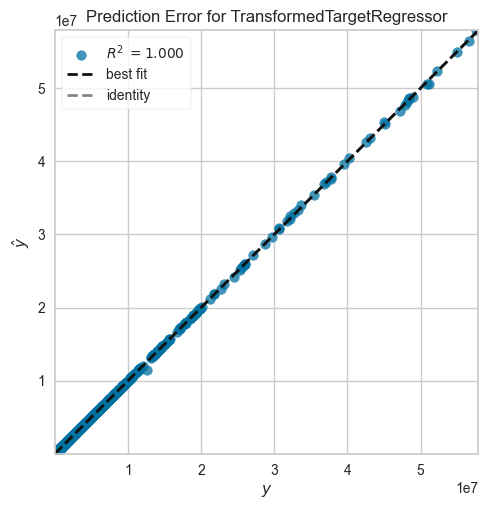

Prediction plot for estimator RandomForestRegressor


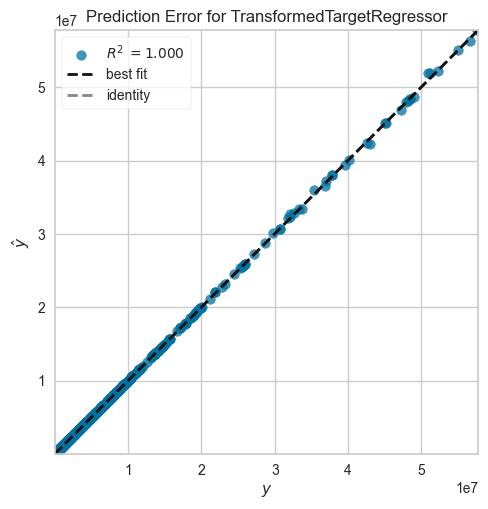

Prediction plot for estimator XGBRegressor


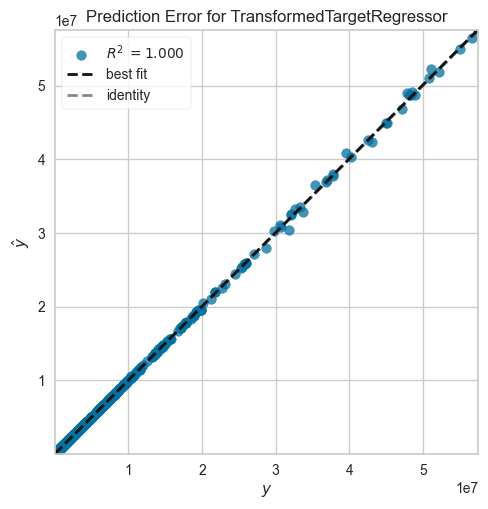

In [13]:
prediction_error_plot(models, x_train, x_test, y_train, y_test)

### Residual Plot


Residual plot for estimator ExtraTreesRegressor


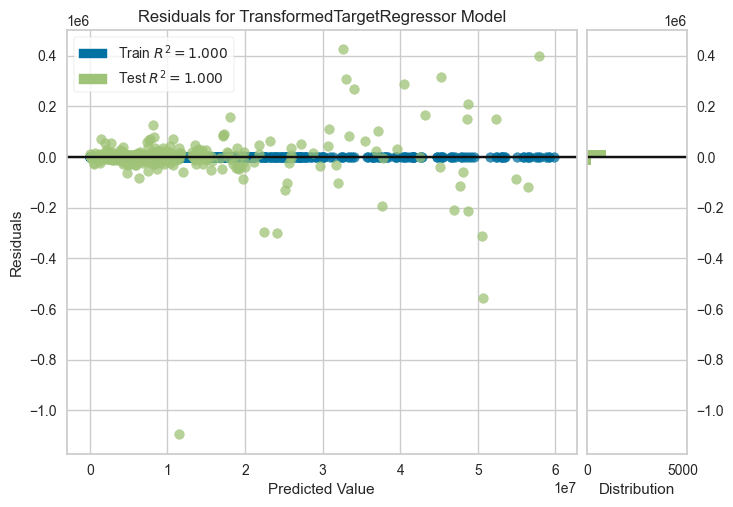

Residual plot for estimator RandomForestRegressor


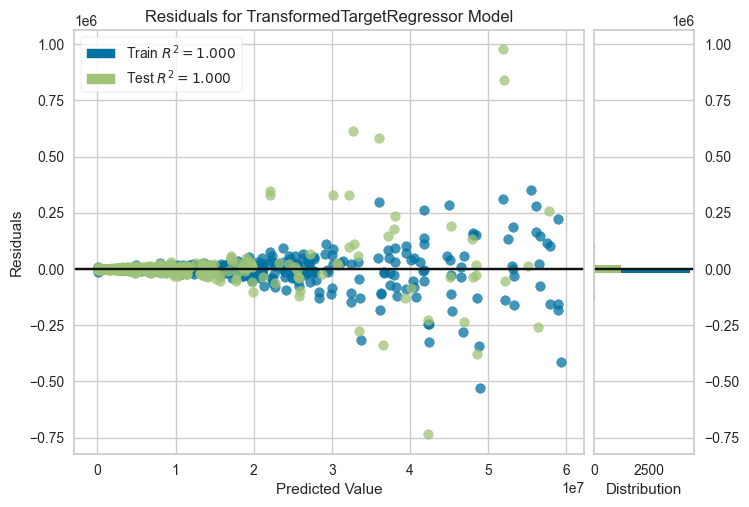

Residual plot for estimator XGBRegressor


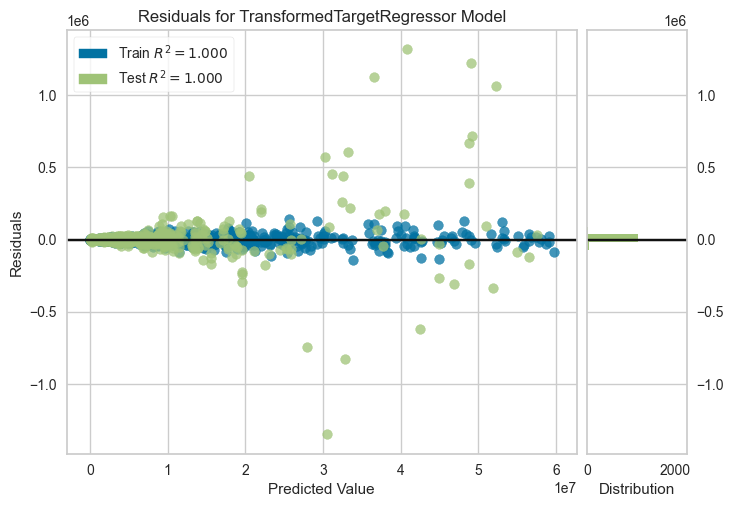

In [14]:
residual_plot(models, x_train, x_test, y_train, y_test)